<a href="https://colab.research.google.com/github/Safa06/Thesis/blob/main/KSC(seminar).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
# VGG16
#import cv2
import tensorflow as tf
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
import scipy.io
from scipy.io import loadmat
#from skimage.transform import resize
from keras.applications.vgg16 import preprocess_input
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint

# **Data Load**

(512, 614, 176)
(512, 614)


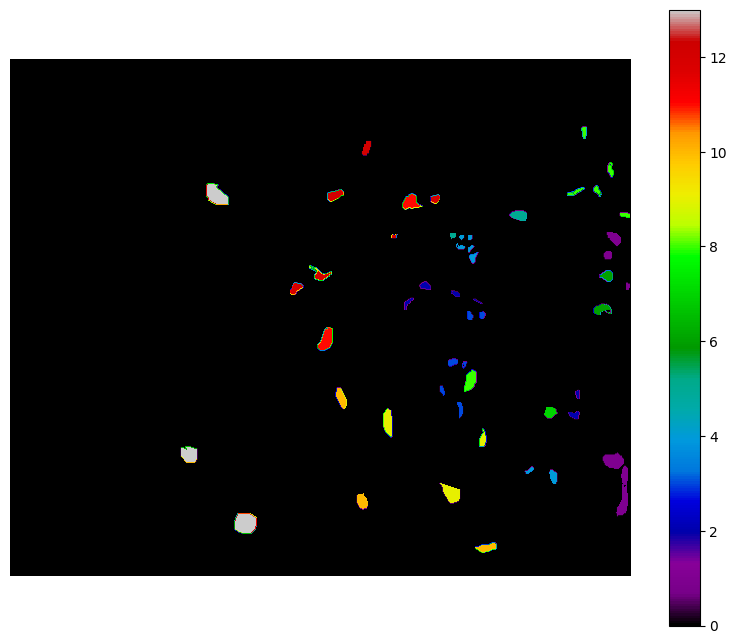

In [ ]:
# DATA load
mat_data1= scipy.io.loadmat('/content/drive/MyDrive/Thdata/KSC_corrected.mat')
mat_data2=scipy.io.loadmat('/content/drive/MyDrive/Thdata/KSC_gt.mat')
X=mat_data1['KSC']
y=mat_data2['KSC_gt']
print(X.shape)
print(y.shape)

plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()


# **Apply PCA,Padding**

In [ ]:
# Apply PCA to minimize band from 200 to 3 band
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

K = 3
X,pca= applyPCA(X,numComponents=K)
print(X.shape, y.shape)



#padding with zero
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


(512, 614, 3) (512, 614)


# **Create Patches**

In [ ]:
# Window for patches
windowSize=23
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

X, y = createImageCubes(X, y, windowSize=windowSize)
#print(X.shape,y.shape)

# **Train-test split**

In [ ]:
#Split train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.7, random_state=42)

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1563, 23, 23, 3) (3648, 23, 23, 3) (1563,) (3648,)


# **Model**

In [ ]:

S = windowSize
L = K
#output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

## input layer
input_layer = (23,23,3)

#for 3D CNN--input_layer=Input(S, S, L, 1)

#Model
model = Sequential()

#Block 1

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding="same",input_shape=(23,23,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu',padding="same"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(MaxPooling2D((2, 2), strides=(2, 2)))
model.add(MaxPooling2D((1, 1), strides=(1, 1)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=13, activation='softmax'))

model.build()
model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 23, 23, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 128)         0         
 g2D)                                                   

# **Epoch starts**

In [ ]:
# checkpoint for saving epochs
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test),batch_size=64,callbacks=callbacks_list)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 2.5319 - accuracy: 0.1727
Epoch 1: accuracy improved from -inf to 0.17274, saving model to best-model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 16s 180ms/step - loss: 2.5319 - accuracy: 0.1727 - val_loss: 2.3643 - val_accuracy: 0.1801
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 2.0907 - accuracy: 0.1727
Epoch 2: accuracy did not improve from 0.17274
25/25 [==============================] - 1s 53ms/step - loss: 2.0907 - accuracy: 0.1727 - val_loss: 2.0106 - val_accuracy: 0.1801
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 1.9331 - accuracy: 0.2700
Epoch 3: accuracy improved from 0.17274 to 0.26999, saving model to best-model.hdf5
25/25 [==============================] - 3s 142ms/step - loss: 1.9331 - accuracy: 0.2700 - val_loss: 1.8571 - val_accuracy: 0.3317
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 1.8379 - accuracy: 0.3180
Epoch 4: accuracy improved from 0.26999 to 0.31798, saving model to best-model.hdf5
25/25 [==============================] - 3s 124ms/step - loss: 1.8379 - accuracy: 0.3180 - val_loss: 1.7327

# **Graph**

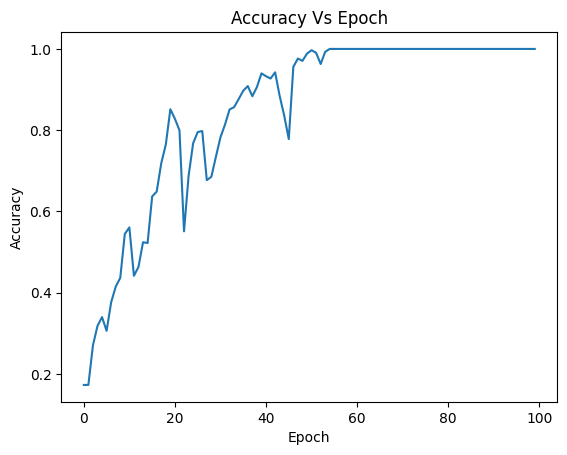

<Figure size 640x480 with 0 Axes>

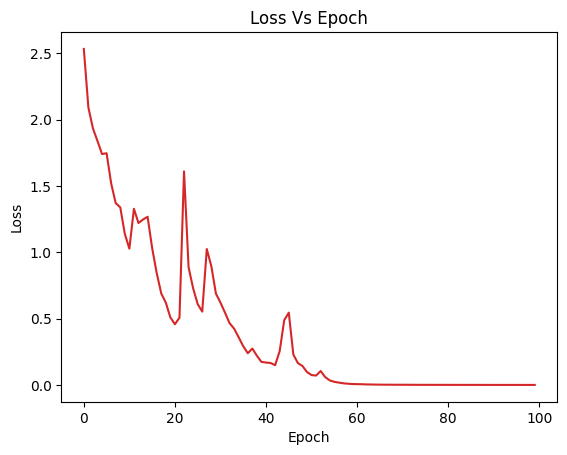

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'],color ='tab:blue')
plt.title('Accuracy Vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy_Vs-Epoch.png',dpi=300)

plt.figure()
plt.plot(history.history['loss'],color ='tab:red')
plt.title('Loss Vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss_Vs-Epoch.png',dpi=300)

# **Testing & Confusion Matrix**

114/114 - 1s - loss: 0.0233 - accuracy: 0.9931 - 1s/epoch - 13ms/step
114/114 [==============================] - 1s 6ms/step
(3648,) (3648, 13) (3648,)


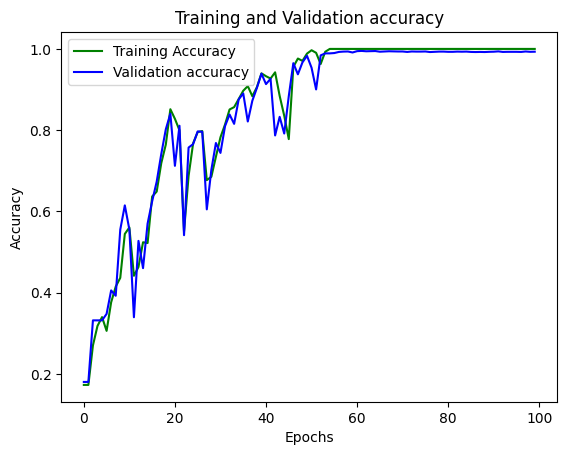

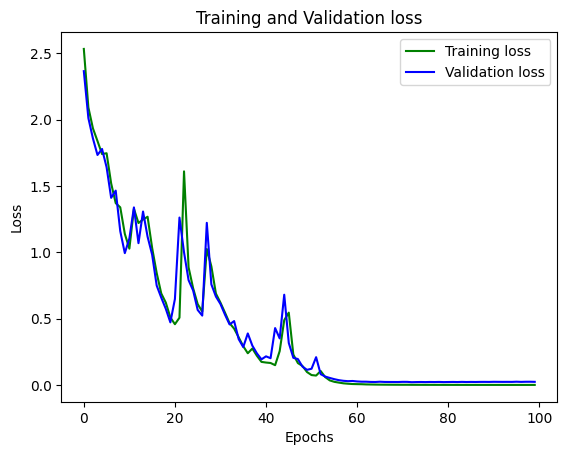

                       precision    recall  f1-score   support

                Scrub       0.99      1.00      0.99       553
         Willow swamp       0.95      0.99      0.97       164
 Cabbage palm hammock       0.99      0.99      0.99       178
         Cabbage palm       0.99      0.92      0.95       182
           Slash pine       1.00      1.00      1.00       118
Oak/broadleaf hammock       0.96      0.99      0.98       157
       Hardwood swamp       1.00      1.00      1.00        79
      Graminoid marsh       1.00      0.98      0.99       291
       Spartina marsh       1.00      1.00      1.00       348
        Cattail marsh       1.00      1.00      1.00       280
           Salt marsh       1.00      1.00      1.00       287
            Mud flats       1.00      1.00      1.00       354
                Water       1.00      1.00      1.00       657

             accuracy                           0.99      3648
            macro avg       0.99      0.99      0.99 

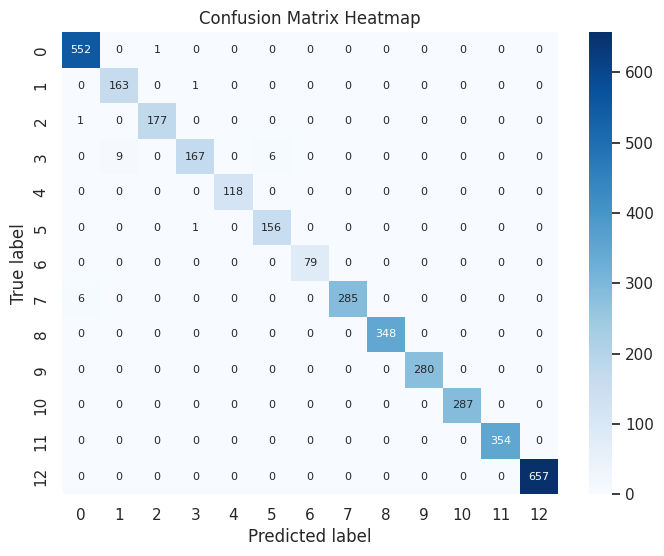

<Figure size 640x480 with 0 Axes>

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)

# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred,axis=1)
print(y_test.shape,y_pred.shape,y_pred_classes.shape)



#Traning and validation accuracy
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
#epochs = range(1,35)
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Traning and validation loss
loss_train = history.history['loss']
loss_val = history.history['val_loss']
#epochs = range(1,35)
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Class names of KSC (13 class)
target_names = ['Scrub','Willow swamp','Cabbage palm hammock','Cabbage palm',
                'Slash pine','Oak/broadleaf hammock','Hardwood swamp',
                'Graminoid marsh','Spartina marsh','Cattail marsh','Salt marsh',
                'Mud flats','Water']



classification = classification_report(y_test,y_pred_classes,  target_names=target_names)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)


# Print the confusion matrix
print(classification,conf_matrix)


#Confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Adjust font scale if needed
sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={"size": 8}, fmt='d')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix Heatmap')
plt.show()
plt.savefig('Conf_matrix_heatmap.png',dpi=300)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TypeError: Invalid shape (5211,) for image data

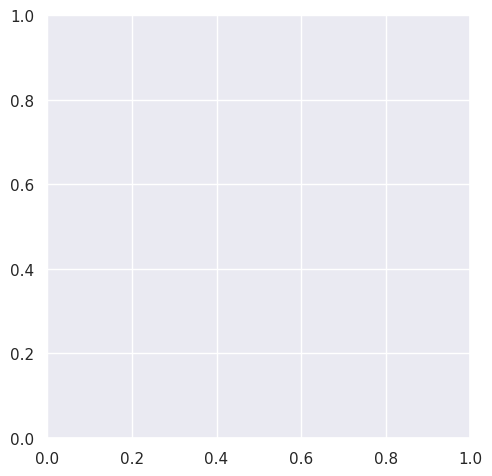

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Assuming y_true is the true ground truth (512x614) and y_pred_classes is the predicted class labels (64x57)

# Reshape y_pred_classes to match the shape of y_true (512x614)
predicted_image = np.zeros((512, 614), dtype=np.uint8)  # Initialize an empty array with the same shape as y_true
predicted_image[:64, :57] = y_pred_classes.reshape((64, 57))  # Fill the corresponding region with the predicted labels

# Create a color map for visualization
# Replace class_colors with a list of colors corresponding to each class
class_colors = [
    [0, 0, 0],       # Class 0: Background (Black)
    [255, 0, 0],     # Class 1: Red
    [0, 255, 0],     # Class 2: Green
    [0, 0, 255],     # Class 3: Blue
    # Add more colors for additional classes if needed
]

# Create a custom color map using the defined colors
cmap = ListedColormap(np.array(class_colors) / 255.0)


# Plot the true ground truth and the predicted ground truth as images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(y, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_colors)-1,extent=(0, 614, 0, 512))
plt.title('True Ground Truth')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(predicted_image, cmap=cmap, interpolation='nearest', vmin=0, vmax=len(class_colors)-1,extent=(0, 614, 0, 512))
plt.title('Predicted Ground Truth')
plt.colorbar()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


# **Classification report shows with Precision, Recall, F1 Score**

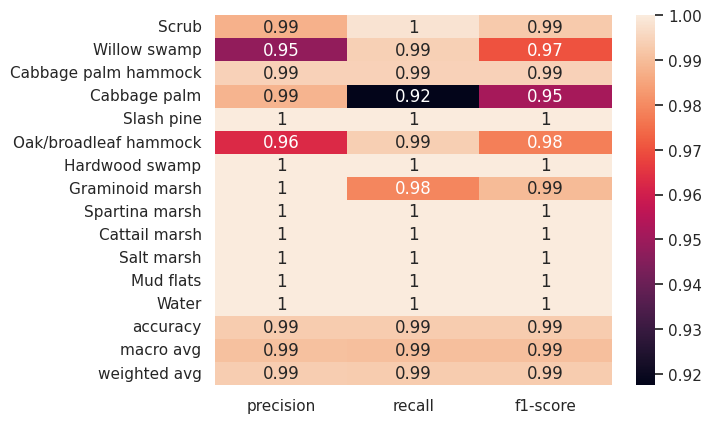

<Figure size 640x480 with 0 Axes>

In [ ]:
#precision,recall,f1 score,support in graph
classification = classification_report(y_test,y_pred_classes,  target_names=target_names,output_dict=True)
classification_df = pd.DataFrame(classification)
sns.heatmap(pd.DataFrame(classification_df).iloc[:-1, :].T, annot=True)
plt.show()
plt.savefig('Precision_recall_f1_sup_heatmap.png',dpi=300)

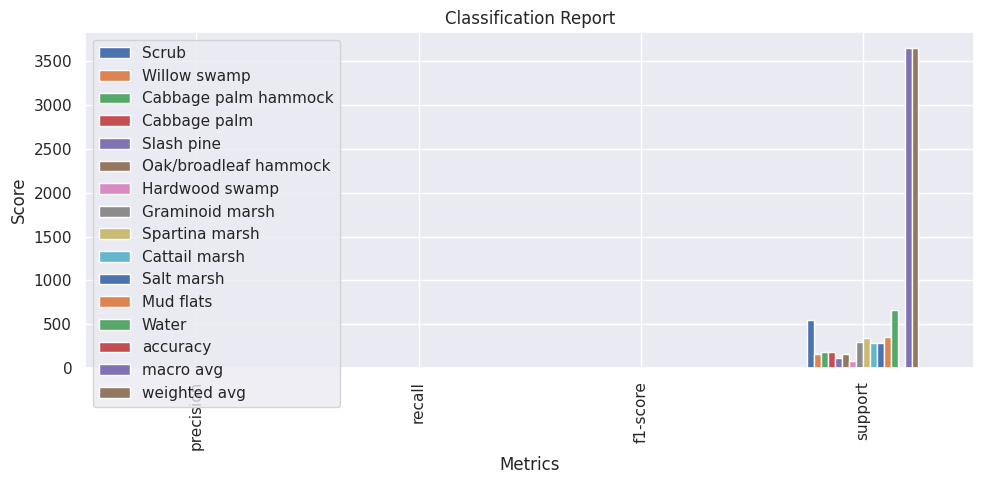

In [ ]:
# Plot the classification report
fig, ax = plt.subplots(figsize=(10, 5))
classification_df = pd.DataFrame(classification)
classification_df.plot(kind='bar', ax=ax)
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Score')
# plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# **Conf_matrix heatmap with class names of KSC**

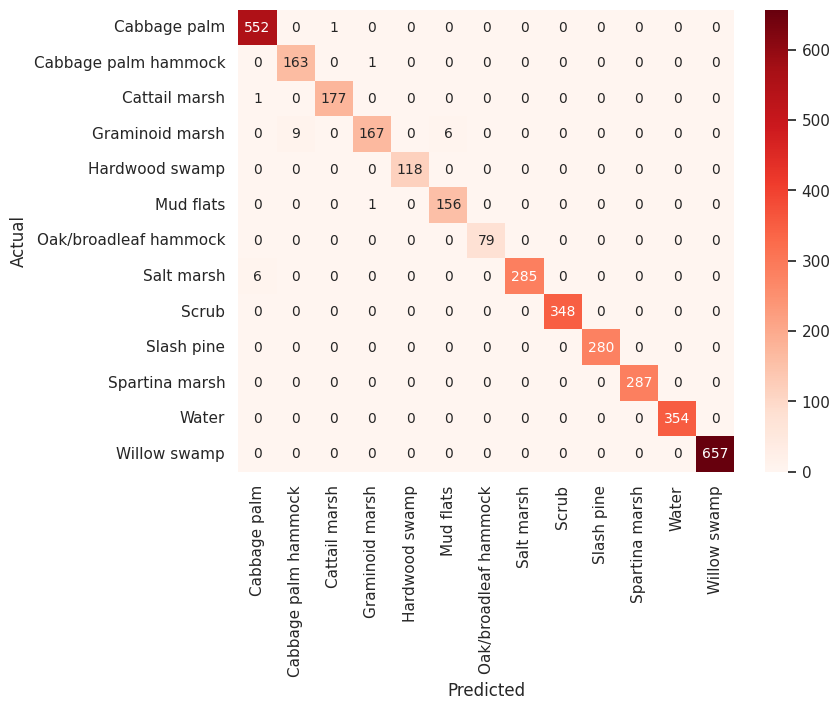

In [ ]:
classification_df = pd.DataFrame(conf_matrix, columns=np.unique(target_names), index = np.unique(target_names))
classification_df.index.name = 'Actual'
classification_df.columns.name = 'Predicted'
plt.figure(figsize = (8,6))
sns.set(font_scale=1)#for label size
sns.heatmap(classification_df, cmap="Reds", annot=True,annot_kws={"size": 10}, fmt='d')
plt.savefig('cmap.png', dpi=300)